In [26]:
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score, rand_score, adjusted_mutual_info_score, \
    normalized_mutual_info_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
from scipy.stats import rankdata
from sklearn.cluster import KMeans, AffinityPropagation, AgglomerativeClustering, DBSCAN, MeanShift, SpectralClustering,OPTICS

In [27]:
df= pd.read_csv("../datasets/ecoli_RL.csv")

In [28]:
global X
X=df.drop(["y"], axis=1)
global y
y=df["y"]

In [29]:
def train_evaluate(params):
    kmeans = KMeans(**params, random_state=0)
    predictions_tr =kmeans.fit_predict(X)
    score  = normalized_mutual_info_score(y, predictions_tr)
    return score

def objective(params):
    return -1.0 * train_evaluate(params)

In [10]:
N=4
def hp_search(hpi):
    if hpi in "n_clusters": 
        return np.random.choice(np.arange(2, 40, 1), N)
    elif hpi in "init":
        k_run = np.random.choice( ['k-means++', 'random'], N)
        k_run_str = [str(n) for n in k_run]
        return k_run_str
    elif hpi in "max_iter":
        return np.random.choice(np.arange(50, 501, 1), N)
    
    elif hpi in "algorithm":
        k_run = np.random.choice( ['auto', 'full', 'elkan'], N)
        return k_run
    if hpi in "n_init": 
        return np.random.choice(np.arange(2, 30, 1), N)
    if hpi in "tol": 
        return np.random.uniform(10 ** (-5), 10 ** (-1), N),

In [11]:

def hyper_opt_run(hpi_list):
    
    hp_trials_lst={}

    for hpi in {"n_clusters","init", "max_iter", "algorithm","n_init"}:
        SEARCH_PARAMS = {
        "n_clusters": hp.choice("n_clusters",np.arange(2, 40, 1)),
        "init": hp.choice("init",['k-means++', 'random']),
        "max_iter": hp.choice("max_iter",np.arange(50, 501, 1)),
        "algorithm": hp.choice("algorithm",['auto', 'full', 'elkan']),
        "n_init": hp.choice("n_init",np.arange(2, 30, 1)),
        'tol': hp.uniform("tol",10 ** (-5), 10 ** (-1)),
        }
        
        SEARCH_PARAMS.pop(hpi)
        k_run=hp_search(hpi)
        trials_lst=[]
        best_lst=[]
        for i in range(0,N):

            FIXED_PARAMS = {
                hpi: k_run[i],
            }
            params = { **SEARCH_PARAMS, **FIXED_PARAMS}
            trials = Trials()
            best = fmin(objective,
                space=params,
                algo=tpe.suggest,
                max_evals=50,
                trials=trials)
            
            trials_lst.append(trials.results)
            best_lst.append(best)
        
        hp_trials_lst[hpi]= trials_lst
    
    return hp_trials_lst
    

100%|██████████| 50/50 [00:07<00:00,  7.04trial/s, best loss: -0.16716383731817971]


In [12]:
def hpi_avg_lossess(hp_trials_lst):
    losses= {}
    avg_losses = {}
    lst_hpi_losses= {}
    for hpi in {"n_clusters","init", "max_iter", "algorithm","n_init"}:
        lst_hpi_losses = hp_trials_lst[hpi]
        losses[hpi] = [[lst_hpi_losses[y][x]["loss"] for x in range(50)] for y in range(N)] 
        avg_losses[hpi] = [sum(x)/len(losses[hpi]) for x in zip(*losses[hpi])]
    

In [13]:

init, ncluster,max_iter,algorithm,n_init=rankdata([avg_losses['init'], avg_losses['n_clusters'],avg_losses['max_iter'],avg_losses['algorithm'],avg_losses['n_init']], method= "ordinal" , axis=0)
# new_avg_loss=np.array([avg_losses['init'], avg_losses['n_clusters'],avg_losses['max_iter'],avg_losses['algorithm']])


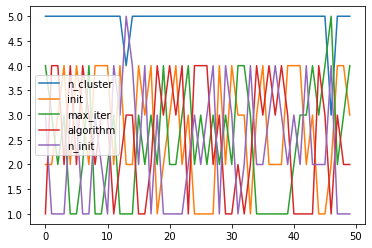

In [14]:
plt.plot(range(0,50),ncluster, label='n_cluster')
plt.plot(range(0,50),init,label='init')
plt.plot(range(0,50),max_iter,label='max_iter')
plt.plot(range(0,50),algorithm,label='algorithm')
plt.plot(range(0,50),n_init,label='n_init')

plt.legend()
plt.show()